Here we use all skill nodes, not only a subset (not only those which have a normalized name)
Also we use all edges, not only the first 125ish
we also do not use pca reduction, but use the full dimensional minilmv2 sbert

In [1]:
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [2]:

import os
!pip install torch==2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
#torch_version = '2.0.0+cu118'
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-${torch.__version__}.html
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-${torch.__version__}.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-${torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu121.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu121.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install sentence-transformers
!pip install torcheval
!pip install matplotlib
!pip install pandas
!pip install tensorboard

Looking in indexes: https://download.pytorch.org/whl/cu121
2.1.0+cu121
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu121.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-daj_8zp_
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-daj_8zp_
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 6938d7f784ee609eb5d0349d5599c9473acd8796
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

/home/amos/mambaforge/envs/pyg_torch21/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# only use skill nodes which have normalized_name != NaN, this is some indication of quality skill (?)
skill_nodes = pd.read_csv('neo4jgraph/skills.csv').reset_index()
job_nodes = pd.read_csv('neo4jgraph/onet_skills_unique.csv')

# drop some skills "or"
# skill_nodes = skill_nodes.loc[~skill_nodes.skill.isin(['or','technology'])]

In [6]:
job_nodes.loc[job_nodes['Alternate Title']=='Inventory Control Analyst']

,index,O*NET-SOC Code,Title,Alternate Title,Short Title,Source(s)
2860,2860,13-1081.02,Logistics Analysts,Inventory Control Analyst,NaN,10


In [7]:
# There are duplicate normalized names
skill_nodes.shape[0]-skill_nodes.normalized_name.unique().shape[0]

660418

In [8]:
# There are not as many skill names which are duplicate
skill_nodes.shape[0]-skill_nodes.skill.unique().shape[0]

11749

In [7]:
# we can not use normalized name instead of skill, because it is ambiguous, e.g. communication points to different normalized names
skill_nodes.loc[skill_nodes.skill=='communication']

,index,skill,category,normalized_name
2229,2229,communication,communication,Third-Party Provider Communication
4059,4059,communication,healthcare,Communication (Including SBAR)
12919,12919,communication,communication,Friendly Communication
16927,16927,communication,communication,radio/telephone communication
19452,19452,communication,communication,communication (phone and email)
...,...,...,...,...
759817,759817,communication,communication,Calling/Applying
762531,762531,communication,communication,Communication
818822,818822,communication,communication,Email/Phone Communication
848577,848577,communication,soft skills,Communication (Phone/Face-to-Face)


In [8]:
skill_nodes.drop_duplicates(subset='skill', inplace=True)

In [9]:

skill_job_edges = pd.read_csv('neo4jgraph/tfidf_skill_job_edge.csv')
#skill_job_edges = skill_job_edges.loc[skill_job_edges.scaled_tfidf>8]
# only use edges where we have the skill and job for from the other files
skill_job_edges = skill_job_edges.loc[skill_job_edges['skill'].isin(skill_nodes['skill'])]
skill_job_edges = skill_job_edges.loc[skill_job_edges['alt_title'].isin(job_nodes.index)]

In [10]:
skill_job_edges

,alt_title,skill,scaled_tfidf,n_jobdesc_used
1,55010,design,9.887307,240
2,55010,or,9.522991,240
5,55010,cg,8.744163,240
7,55010,video,7.979898,240
10,55010,visual effects,6.299518,240
...,...,...,...,...
7926041,15285,engineering,5.864380,1
7926046,15285,us,4.829347,1
7926049,15285,it,4.486111,1
7926050,15285,development,4.434249,1


In [11]:
# map 3,6,7,3,3,... to 1,2,3,1,1 ...
skillmapping ={}
for i,skill in enumerate(skill_nodes.skill.unique()):
    skillmapping[skill] =i

jobmapping ={}
jobmapping_index_to_title_alttile = {}
for i, index in enumerate(job_nodes['index'].unique()):
    jobmapping[index] =i

for _, row in job_nodes.iterrows():
    if type(row['Title']) == str:
        a = row['Title']
    else:
        a = ''
    
    jobmapping_index_to_title_alttile[row['index']] = a+'/'+row['Alternate Title']

inverted_skillmapping = {v:k for k,v in skillmapping.items()}
inverted_jobmapping = {v:k for k,v in jobmapping.items()}

In [12]:
skill_job_edges['skill_dst'] = skill_job_edges['skill'].apply(lambda x:skillmapping[x])
skill_job_edges['job_src'] = skill_job_edges['alt_title'].apply(lambda x:jobmapping[x])

In [13]:
# normalization and removal of job-skill edges
# first group by jobs and limit the skills for each job to 175
# then normalize those tfidf edgeweights
# then group by skill and limit edges to 125 for skills (ordered by normalized tf-idf)
skill_job_edges = skill_job_edges.groupby('job_src').apply(lambda group: group.nlargest(175,'scaled_tfidf')).reset_index(drop=True)
summed_tfidf_per_job = skill_job_edges.groupby('job_src').sum()
skill_job_edges['sum'] = skill_job_edges['job_src'].apply(lambda x: summed_tfidf_per_job.loc[x]['scaled_tfidf'])
skill_job_edges['normalized_tfidf'] =  skill_job_edges['scaled_tfidf']/skill_job_edges['sum']
skill_job_edges = skill_job_edges.groupby('skill_dst').apply(lambda group: group.nlargest(125,'normalized_tfidf')).reset_index(drop=True)
# we dont do the second round of normalization

/tmp/ipykernel_5731/3367385361.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summed_tfidf_per_job = skill_job_edges.groupby('job_src').sum()


In [14]:
# normalization and removing of skill-skill edges


In [15]:


#for each alt title select the first 125 skill_job edges, ordered by tfidf
# skill_job_edges = skill_job_edges.groupby('job_src')
# skill_job_edges = skill_job_edges.groupby('job_src').apply(lambda group: group.nlargest(125,'scaled_tfidf')).reset_index(drop=True)

# for each skill only use the 125 edges with the highest tf-idf score
#skill_job_edges = skill_job_edges.groupby('skill').apply(lambda group: group.nlargest(125,'scaled_tfidf')).reset_index(drop=True)

In [16]:
skill_job_edges

,alt_title,skill,scaled_tfidf,n_jobdesc_used,skill_dst,job_src,sum,normalized_tfidf
0,24372,working in shift,0.935676,25,10,24370,203.551902,0.004597
1,2930,digital creators,1.990591,103,26,2930,284.243043,0.007003
2,3119,digital creators,0.642614,47,26,3119,251.646329,0.002554
3,4758,integrated solutions,0.666242,2355,41,4758,329.999732,0.002019
4,2787,integrated solutions,0.160829,38,41,2787,211.244072,0.000761
...,...,...,...,...,...,...,...,...
750778,158,company manuals,1.418798,10,860253,158,234.533077,0.006049
750779,6068,environmental inspection,1.265448,16,860263,6068,322.010740,0.003930
750780,2825,remote storage,0.532376,187,860274,2825,204.673167,0.002601
750781,53572,remote storage,0.306624,123,860274,53570,162.977214,0.001881


In [17]:
onet_alttitles = pd.read_csv('neo4jgraph/onet_alt_titles_unique.csv')
del onet_alttitles['Unnamed: 0']

In [18]:
onet_alttitle_str_mapping = {}
for i,row in onet_alttitles.iterrows():
    onet_alttitle_str_mapping[row['index']] = row['Alternate Title']

In [19]:
import torch
mappings = {
    'onet_alttitle_str_mapping':onet_alttitle_str_mapping,
    'skillmapping':skillmapping,
    'inverted_skillmapping':inverted_skillmapping,
    'jobmapping':jobmapping,
    'inverted_jobmapping':inverted_jobmapping,
    'jobmapping_index_to_title_alttile':jobmapping_index_to_title_alttile
}

torch.save(mappings, 'Job_Skill_HeteroData_name_mappings_withdupes_fulldataset_v1.pt')

In [22]:
len(jobmapping.keys())

55653

In [20]:
wdwd

NameError: name 'wdwd' is not defined

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
skill_sbert_embeddings = embedder.encode(skill_nodes['skill'].tolist(), convert_to_numpy=True, device='cuda')
job_sbert_embeddings = embedder.encode(job_nodes['Alternate Title'].tolist(), convert_to_numpy=True, device='cuda')

: 

In [ ]:
# add job-job edges, dataset see https://www.onetcenter.org/dictionary/26.3/excel/related_occupations.html
job_job_edges = pd.read_csv('neo4jgraph/onet_related_occupations.csv')

In [ ]:
job_job_edges

,O*NET-SOC Code,Title,Related O*NET-SOC Code,Related Title,Relatedness Tier,index_x,index_y
0,11-1011.00,Chief Executives,11-1021.00,General and Operations Managers,Primary-Short,54641,54643
1,11-1031.00,Legislators,11-1021.00,General and Operations Managers,Supplemental,54644,54643
2,11-2021.00,Marketing Managers,11-1021.00,General and Operations Managers,Supplemental,54646,54643
3,11-2022.00,Sales Managers,11-1021.00,General and Operations Managers,Primary-Long,54647,54643
4,11-2032.00,Public Relations Managers,11-1021.00,General and Operations Managers,Primary-Long,54648,54643
...,...,...,...,...,...,...,...
18379,53-2022.00,Airfield Operations Specialists,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Primary-Short,55590,55587
18380,53-2031.00,Flight Attendants,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Supplemental,55591,55587
18381,53-5021.00,"Captains, Mates, and Pilots of Water Vessels",53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Primary-Short,55608,55587
18382,53-5022.00,Motorboat Operators,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Supplemental,55609,55587


In [ ]:
job_job_edges['job_src'] = job_job_edges['index_x'].apply(lambda x: jobmapping[x])
job_job_edges['job_dst'] = job_job_edges['index_y'].apply(lambda x: jobmapping[x])
relatedness_weight = {
    'Supplemental':0.5,
    'Primary-Long':0.7,
    'Primary-Short':1
}
job_job_edges['relatedness_weight'] = job_job_edges['Relatedness Tier'].apply(lambda x: relatedness_weight[x])

In [ ]:
skill_skill_edges = pd.read_csv('neo4jgraph/skill_skill_edges.csv')


In [ ]:
#filter out potentially bad skills (which are not in our original skillmapping)
skill_skill_edges = skill_skill_edges.loc[(skill_skill_edges.skill.isin(list(skillmapping.keys()))) & (skill_skill_edges.related_skill.isin(list(skillmapping.keys())))]

In [ ]:
skill_skill_edges['skill_src'] = skill_skill_edges['skill'].apply(lambda x: skillmapping[x])
skill_skill_edges['skill_dst'] = skill_skill_edges['related_skill'].apply(lambda x: skillmapping[x])

In [ ]:
# # only take largest 125 "both directions" (not ideal)
# skill_skill_edges =  skill_skill_edges.groupby('skill_src').apply(lambda group: group.nlargest(125,'cosine_sim_score')).reset_index(drop=True)
# skill_skill_edges =  skill_skill_edges.groupby('skill_dst').apply(lambda group: group.nlargest(125,'cosine_sim_score')).reset_index(drop=True)

In [ ]:
from torch_geometric.data import HeteroData
import torch

data = HeteroData()
data['Skill'].x = torch.tensor(skill_sbert_embeddings)
data['Job'].x = torch.tensor(job_sbert_embeddings)

data['Job','REQUIRES','Skill'].edge_index = torch.tensor(skill_job_edges[['job_src','skill_dst']].to_numpy().T)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index = torch.tensor(skill_skill_edges[['skill_src','skill_dst']].to_numpy().T)
data['Job','IS_SIMILAR_JOB','Job'].edge_index = torch.tensor(job_job_edges[['job_src','job_dst']].to_numpy().T)


data['Job','REQUIRES','Skill'].edge_weight = torch.tensor(skill_job_edges['normalized_tfidf'].to_numpy()).to(torch.float)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_weight = torch.tensor(skill_skill_edges['cosine_sim_score'].to_numpy()).to(torch.float)
data['Job','IS_SIMILAR_JOB','Job'].edge_weight = torch.tensor(job_job_edges['relatedness_weight'].to_numpy()).to(torch.float)

In [ ]:
skill_job_edges['normalized_tfidf'].min()

5.022261002228467e-06

In [ ]:
skill_skill_edges['cosine_sim_score'].min()

0.5

In [ ]:
job_job_edges['relatedness_weight'].min()

0.5

In [ ]:
data['Job'].x.shape

torch.Size([55653, 384])

In [ ]:
skill_skill_edges_temp = skill_skill_edges

In [ ]:
skill_skill_edges_temp.shape

(2259425, 7)

Jobs: 55653, actual Jobs used (in at least one edge): 16330
Skills: 860294, actual Skills used (in at least one edge): 213197

Following metrics only include Skills and Jobs with at least one edge:

JRS edges: 750783
Average JRS Job degree: 45.97568893432617, Skill: 3.521545886993408
Median JRS Job degree: 35.0, Skill: 3.0
Max JRS Job degree: 149.0, Skill: 125.0

S_SIM_S edges: 2259425
Average S_SIM_S degree: 21.195653915405273
Median S_SIM_S degree: 5.0
Max S_SIM_S degree: 2099.0
J_SIM_J edges: 18384
Average J_SIM_J degree: 2.2515616416931152
Median J_SIM_J degree: 37.0
Max J_SIM_J degree: 126.0

Average total degree: Job: 48.22724914550781
Average total degree: Skill: 24.717201232910156


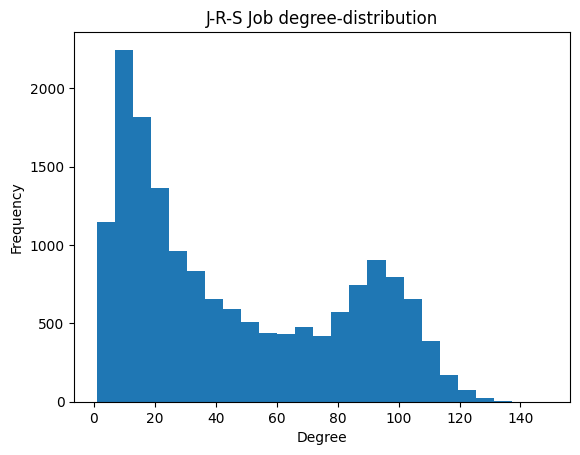

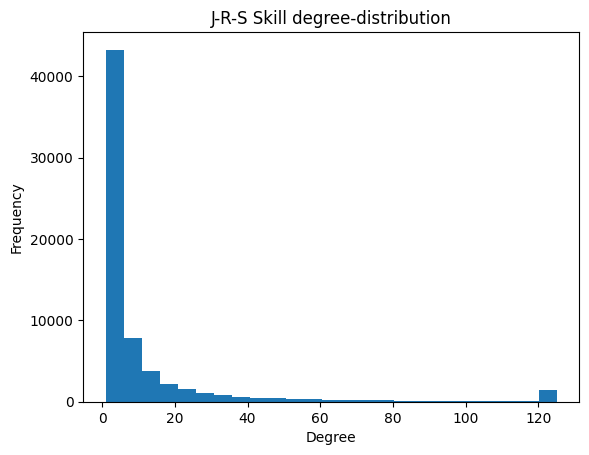

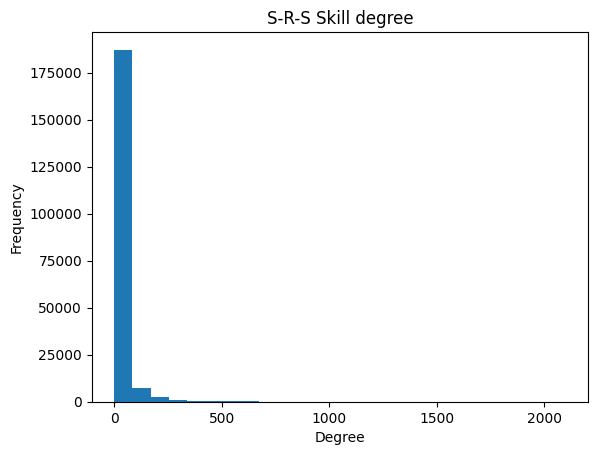

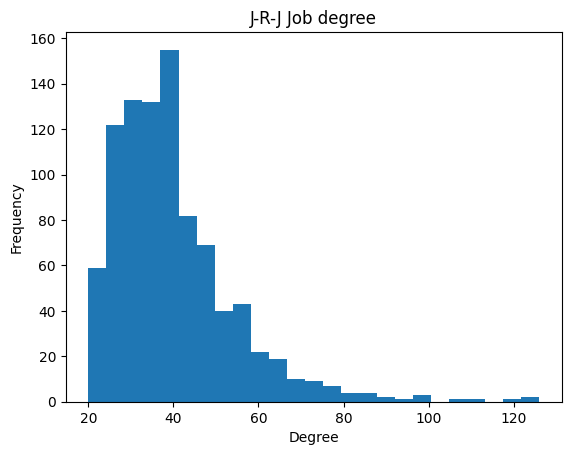

<Figure size 640x480 with 0 Axes>

In [ ]:
# Look at node degree statistics

from torch_geometric.utils import to_dense_adj, degree



job_n = data['Job'].x.shape[0]
skill_n = data['Skill'].x.shape[0]

JRS_J = degree(data['Job','REQUIRES','Skill'].edge_index[0], num_nodes=job_n)
JRS_S = degree(data['Job','REQUIRES','Skill'].edge_index[1], num_nodes=skill_n)
S_SIM_S = degree(data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index.flatten(), num_nodes=skill_n)
J_SIM_J = degree(data['Job','IS_SIMILAR_JOB','Job'].edge_index.flatten(), num_nodes=job_n)

actual_skill_n = torch.nonzero(JRS_S+S_SIM_S).shape[0] # only skills which have any edge at all
actual_job_n = torch.nonzero(JRS_J+J_SIM_J).shape[0] # only job which have any edge at all
print(f'Jobs: {job_n}, actual Jobs used (in at least one edge): {actual_job_n}')
print(f'Skills: {skill_n}, actual Skills used (in at least one edge): {actual_skill_n}')

print('\nFollowing metrics only include Skills and Jobs with at least one edge:\n')

print(f"JRS edges: {data['Job','REQUIRES','Skill'].edge_index.shape[1]}")
print(f'Average JRS Job degree: {torch.sum(JRS_J)/actual_job_n}, Skill: {torch.sum(JRS_S)/actual_skill_n}')
print(f'Median JRS Job degree: {torch.median(JRS_J[JRS_J!=0])}, Skill: {torch.median(JRS_S[JRS_S!=0])}')
print(f'Max JRS Job degree: {torch.max(JRS_J)}, Skill: {torch.max(JRS_S)}\n')

print(f"S_SIM_S edges: {data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index.shape[1]}")
print(f'Average S_SIM_S degree: {torch.sum(S_SIM_S)/actual_skill_n}')
print(f'Median S_SIM_S degree: {torch.median(S_SIM_S[S_SIM_S!=0])}')
print(f'Max S_SIM_S degree: {torch.max(S_SIM_S)}')

print(f'J_SIM_J edges: {data["Job", "IS_SIMILAR_JOB", "Job"].edge_index.shape[1]}')
print(f'Average J_SIM_J degree: {torch.sum(J_SIM_J)/actual_job_n}')
print(f'Median J_SIM_J degree: {torch.median(J_SIM_J[J_SIM_J!=0])}')
print(f'Max J_SIM_J degree: {torch.max(J_SIM_J)}\n')

print(f'Average total degree: Job: {(torch.sum(JRS_J)+torch.sum(J_SIM_J))/actual_job_n}')
print(f'Average total degree: Skill: {(torch.sum(JRS_S)+torch.sum(S_SIM_S))/actual_skill_n}')

import matplotlib.pyplot as plt
import os 

os.makedirs("plot_images/", exist_ok=True)

# Plot and save the first plot
plt.title('J-R-S Job degree-distribution')
plt.hist(JRS_J[JRS_J != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/JRS_J_degree_distribution.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the second plot
plt.title('J-R-S Skill degree-distribution')
plt.hist(JRS_S[JRS_S != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/JRS_S_degree_distribution.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the third plot
plt.title('S-R-S Skill degree')
plt.hist(S_SIM_S[S_SIM_S != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/S_SIM_S_skill_degree.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

# Plot and save the fourth plot
plt.title('J-R-J Job degree')
plt.hist(J_SIM_J[J_SIM_J != 0], bins=25)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('plot_images/J_SIM_J_job_degree.svg', format='svg')
plt.show()
plt.clf()  # Clear the current figure

In [ ]:
ax\axa

In [ ]:
# Add features:
# - node degree
# - normalize edge weights by node degree
# - (triangle count)


# add node degree statistics:

job_degrees = torch.cat((JRS_J.reshape(-1,1) / 125, J_SIM_J.reshape(-1,1)/ 125), dim=1) # divide by approx. max degrees
skill_degrees = torch.cat((JRS_S.reshape(-1,1) / 125, S_SIM_S.reshape(-1,1)/ 125), dim=1) # divide by approx. max degrees

data['Job'].x = torch.cat((data['Job'].x, job_degrees), dim=1)
data['Skill'].x = torch.cat((data['Skill'].x, skill_degrees), dim=1)

# normalize edge weights by node degree

In [ ]:
from torch_sparse import SparseTensor
from tqdm.auto import tqdm
import torch
import gc
# adj_matmul
# row1 to rowS * full_matrix
# rowS+1 to rowT * full_matrix
# ....

# def blockwise_sparse_square_mmul(adj_matrix, blocks=None):
#     row_blocks = []
    
#     if blocks is None:
#         row_block_size = 10000
#         rows = adj_matrix.size(0)
#         for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
#             start = block
#             end = min(block+row_block_size, rows)
#             row_blocks.append(adj_matrix[start:end].spspmm(adj_matrix))
#     else:
#         for block in tqdm(blocks, desc='blockwise sparse matrix-multiplication'):
#             row_blocks.append(block.spspmm(adj_matrix))

#     return row_blocks


# def blockwise_sparse_get_diag(blocks):
#     diags = []
#     for block in tqdm(blocks, desc='get blockwise sparse matrix diagonal'):
#         diags.append(get_diag(block))
    
#     return torch.cat(diags, dim=0)

def triangle_count(adj_matrix:SparseTensor):
    # adj_matmul, blockwise, so kernel does not crash
    # diag1((row1 to rowS) * full_matrix * full_matrix)
    # diag2((rowS+1 to rowR) * full_matrix * full_matrix)
    # ....
    diags = []
    
    row_block_size = 400
    rows = adj_matrix.size(0)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(device)
    with torch.no_grad():
        
        adj_matrix = adj_matrix.to(device)
        for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
            torch.cuda.empty_cache()
            gc.collect()
            start = block
            end = min(block+row_block_size, rows)
            adj_pow_3_block = adj_matrix[start:end].spspmm(adj_matrix).spspmm(adj_matrix)
            diag_block = get_diag(adj_pow_3_block[:,start:].cpu()).cpu()
            diags.append(diag_block)
            # diag = torch.eye(end)
            # indices_i, indices_j = diag.nonzero().unbind(dim=1)
            
            # A = adj_pow_2_block[indices_i]
            # B = adj_matrix[:, indices_j]
            # print(A, t(B))
            # print(type(B), type(A))
            # print(A.size(0), A.size(1), B.size(0), B.size(1))
            #C = A * t(B)
            #C = reduction(C, dim=1)
            
           
            #print(C)
            
            
            
    
    return 1/2 * torch.cat(diags, dim=0)
        
from torch_geometric.utils import to_undirected
from torch_sparse import SparseTensor
from torch_sparse.diag import get_diag

def undirected_triangle_counts(edge_index, max_num_nodes): 
    """Get triangles **per node**, to get count for whole graph, divide by 3"""
    ud = to_undirected(edge_index)
    
    adj_matrix = SparseTensor(row=ud[0], col=ud[1], value=torch.ones(ud[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))
    #adj_matrix = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]), (max_num_nodes, max_num_nodes))
    #adj_matrix = torch.sparse_csr_tensor(ud[0], ud[1], values=torch.ones(ud[1].shape[0]), dtype=torch.float32).to_sparse_coo()
    triangles = triangle_count(adj_matrix) 
    return triangles

In [ ]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except: pass

<class 'torch.Tensor'> torch.Size([55653, 2])
<class 'torch.Tensor'> torch.Size([860294, 2])
<class 'torch.Tensor'> torch.Size([55653, 386])
<class 'torch.Tensor'> torch.Size([860294, 386])
<class 'torch.Tensor'> torch.Size([19])


/home/amos/mambaforge/envs/pyg_torch21/lib/python3.10/site-packages/torch_geometric/contrib/__init__.py:8: UserWarning: 'torch_geometric.contrib' contains experimental code and is subject to change. Please use with caution.
  warnings.warn(


<class 'torch.Tensor'> torch.Size([1, 512])
<class 'torch.Tensor'> torch.Size([1, 512])
<class 'torch.nn.parameter.Parameter'> torch.Size([30522, 384])
<class 'torch.nn.parameter.Parameter'> torch.Size([512, 384])
<class 'torch.nn.parameter.Parameter'> torch.Size([2, 384])
<class 'torch.nn.parameter.Parameter'> torch.Size([384])
<class 'torch.nn.parameter.Parameter'> torch.Size([384])
<class 'torch.nn.parameter.Parameter'> torch.Size([384, 384])
<class 'torch.nn.parameter.Parameter'> torch.Size([384])
<class 'torch.nn.parameter.Parameter'> torch.Size([1536, 384])
<class 'torch.nn.parameter.Parameter'> torch.Size([1536])
<class 'torch.nn.parameter.Parameter'> torch.Size([384, 1536])
<class 'torch.nn.parameter.Parameter'> torch.Size([384])
<class 'torch.nn.parameter.Parameter'> torch.Size([384])
<class 'torch.nn.parameter.Parameter'> torch.Size([384])
<class 'torch.nn.parameter.Parameter'> torch.Size([1536, 384])
<class 'torch.nn.parameter.Parameter'> torch.Size([1536])
<class 'torch.nn.

In [ ]:
# from torch_sparse import SparseTensor
# adj = torch.tensor(
#     [
#         [0,1,1,1,1],
#         [1,0,1,0,1],
#         [1,1,0,1,0],
#         [1,0,1,0,1],
#         [1,1,0,1,0]
#     ]
# ).to(torch.float)
# X = SparseTensor.from_dense(adj)
# triangles = triangle_count(X)
# triangles
#adj_matrix = SparseTensor(row=ud[0], col=ud[1], value=torch.ones(ud[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))

In [ ]:
homogeneous_data = data.to_homogeneous()
homogenous_triangles = undirected_triangle_counts(homogeneous_data.edge_index, homogeneous_data.x.shape[0])
# max triangles: 9000


cuda


blockwise sparse matrix-multiplication: 100%|██████████| 2290/2290 [17:10<00:00,  2.22it/s]


In [ ]:
Job_homogeneous_triangles = homogenous_triangles[homogeneous_data.node_type == 1]
Skill_homogeneous_triangles = homogenous_triangles[homogeneous_data.node_type != 1]

In [ ]:
actual_s_triangles = Skill_homogeneous_triangles[(JRS_S+S_SIM_S)!=0] 
actual_j_triangles = Job_homogeneous_triangles[(JRS_J+J_SIM_J)!=0] 

print(f'Median triangles of skill nodes: {actual_s_triangles.median()}, mean: {actual_s_triangles.mean()}, max: {actual_s_triangles.max()}, min: {actual_s_triangles.min()}')
print(f'Median triangles of job nodes: {actual_j_triangles.median()}, mean: {actual_j_triangles.mean()}, max: {actual_j_triangles.max()}, min: {actual_s_triangles.min()}')

Median triangles of skill nodes: 3.0, mean: 255.61123657226562, max: 65380.0, min: 0.0
Median triangles of job nodes: 11.0, mean: 46.673301696777344, max: 2059.0, min: 0.0


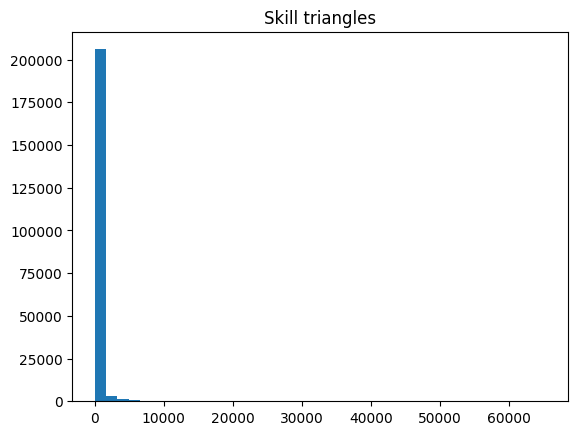

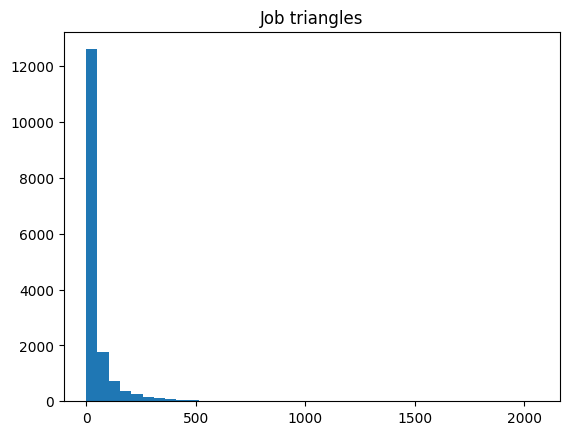

In [ ]:
plt.title('Skill triangles')
plt.hist(actual_s_triangles.numpy(), bins=40)
plt.show()
plt.title('Job triangles')
plt.hist(actual_j_triangles.numpy(), bins=40)
plt.show()

In [ ]:
data

HeteroData(
  Skill={ x=[860294, 388] },
  Job={ x=[55653, 388] },
  (Job, REQUIRES, Skill)={
    edge_index=[2, 750783],
    edge_weight=[750783],
  },
  (Skill, IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 2259425],
    edge_weight=[2259425],
  },
  (Job, IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18384],
    edge_weight=[18384],
  },
  (Skill, rev_REQUIRES, Job)={
    edge_index=[2, 750783],
    edge_weight=[750783],
  },
  (Skill, rev_IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 2259425],
    edge_weight=[2259425],
  },
  (Job, rev_IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18384],
    edge_weight=[18384],
  }
)

In [ ]:
J_SIM_J_triangles = undirected_triangle_counts(data['Job','IS_SIMILAR_JOB', 'Job'].edge_index, data['Job'].x.shape[0])
S_SIM_S_triangles = undirected_triangle_counts(data['Skill','IS_SIMILAR_SKILL', 'Skill'].edge_index, data['Skill'].x.shape[0])

cuda


blockwise sparse matrix-multiplication:   0%|          | 0/140 [00:00<?, ?it/s]

blockwise sparse matrix-multiplication: 100%|██████████| 140/140 [00:27<00:00,  5.11it/s]


cuda


blockwise sparse matrix-multiplication: 100%|██████████| 2151/2151 [10:42<00:00,  3.35it/s]


In [ ]:
actual_s_triangles = S_SIM_S_triangles[(JRS_S+S_SIM_S)!=0] 
actual_j_triangles = J_SIM_J_triangles[(JRS_J+J_SIM_J)!=0] 

print(f'Median triangles of skill nodes for skill-skill edges: {actual_s_triangles.median()}, mean: {actual_s_triangles.mean()}, max: {actual_s_triangles.max()}, min: {actual_s_triangles.min()}')
print(f'Median triangles of job nodes for job-job edges: {actual_j_triangles.median()}, mean: {actual_j_triangles.mean()}, max: {actual_j_triangles.max()}, min: {actual_s_triangles.min()}')

Median triangles of skill nodes for skill-skill edges: 3.0, mean: 250.30715942382812, max: 65380.0, min: 0.0
Median triangles of job nodes for job-job edges: 0.0, mean: 9.845253944396973, max: 1284.0, min: 0.0


In [ ]:
Skill_homogeneous_triangles.max(), Job_homogeneous_triangles.max(), S_SIM_S_triangles.max(), J_SIM_J_triangles.max()

(tensor(65380.), tensor(2059.), tensor(65380.), tensor(1284.))

tensor(2059.)

In [ ]:
data['Skill'].x = torch.cat((data['Skill'].x, Skill_homogeneous_triangles.reshape(-1,1)/65380), dim=1) # normalize by max 9285.0
data['Job'].x = torch.cat((data['Job'].x, Job_homogeneous_triangles.reshape(-1,1)/2059), dim=1) # normalize by max 1320

data['Skill'].x = torch.cat((data['Skill'].x, S_SIM_S_triangles.reshape(-1,1)/65380), dim=1) # normalize by max 9285.0
data['Job'].x = torch.cat((data['Job'].x, J_SIM_J_triangles.reshape(-1,1)/1284), dim=1) # normalize by max 1320

In [ ]:
data.has_isolated_nodes(), data.has_self_loops()

(True, False)

In [ ]:
#data = data.to(device)

In [ ]:
import torch_geometric.transforms as T

transform = T.Compose([
       #T.RemoveIsolatedNodes(),
       T.RemoveDuplicatedEdges(),
       T.ToUndirected(merge=False) # don't merge reversed edges into the original edge type
])

data = transform(data)


In [ ]:
# torch.save(data.to_dict(), path)
# data = Data.from_dict(torch.load(path))

In [ ]:
qrawwdadad

In [ ]:
import os
import torch
from torch_geometric.data import HeteroData


filename = 'Job_Skill_HeteroData_withdupes_fulldataset_v1.pt'
if os.path.exists('./'+filename):
    data = HeteroData.from_dict(torch.load('./'+filename))
    print('loading saved heterodata object')
else:
    torch.save(data.to_dict(), './'+filename)

loading saved heterodata object


In [ ]:
data

In [ ]:
data['Job', 'REQUIRES', 'Skill'].edge_weight.median()

tensor(0.0050)

In [ ]:
data['Job', 'REQUIRES', 'Skill'].edge_weight.median()

(array([7.37341e+05, 1.01930e+04, 2.05700e+03, 6.17000e+02, 2.45000e+02,
        1.22000e+02, 5.90000e+01, 4.00000e+01, 1.90000e+01, 9.00000e+01]),
 array([5.02226112e-06, 1.00004517e-01, 2.00004011e-01, 3.00003529e-01,
        4.00003016e-01, 5.00002503e-01, 6.00001991e-01, 7.00001478e-01,
        8.00001025e-01, 9.00000513e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

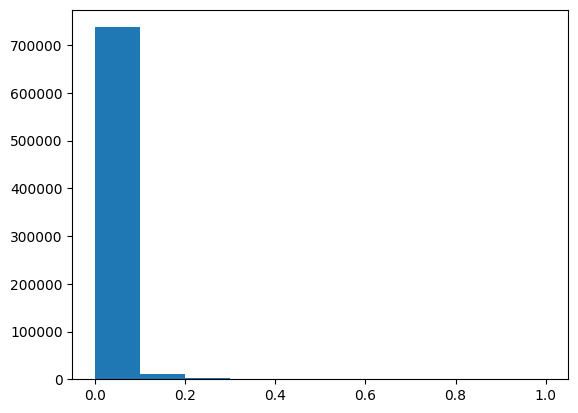

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(data['Job', 'REQUIRES', 'Skill'].edge_weight)